# QPIE and IQFT

In [32]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import matplotlib.pyplot as plt
from qiskit.visualization import array_to_latex
from scipy.fft import fft2, ifft2
from skimage import io
from skimage.transform import resize
import h5py
from skimage import color

Quantum Probability Image Enconding (QPIE) is an image encoding for quantum computers, where the color information encoded in the amplitudes. The state is given by $|I\rangle = \sum_{i=0}^{2^{2n-1}}c_i|i\rangle$, with $c_i = \frac{I'(i)}{||I'||}$ and $I' = (I_{1,1},I_{2,1},...,I_{n,n})^T$ are is flatten image pixel values. 

In [33]:
def qpie_circuit(im): #for square image 2^n * 2^n

    n = int(np.log2(len(im)))

    vals = im.flatten()
    vals = vals/np.linalg.norm(vals) #normalize coefficients

    qc = QuantumCircuit(2*n)

    qc.initialize(vals)

    return qc

float64


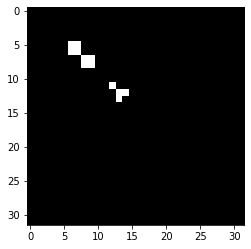

In [34]:
im = np.zeros((32,32))
im[5,6] = 1
im[6,6] = 1
im[5,7] = 1
im[6,7] = 1
im[7,8] = 1
im[8,8] = 1
im[7,9] = 1
im[8,9] = 1
im[11,12] = 1
im[12,13] = 1
im[13,13] = 1
im[12,14] = 1
plt.imshow(im,cmap='gray')
print(im.dtype)

complex128


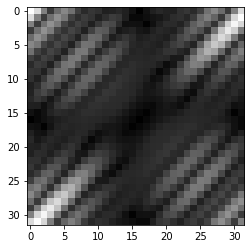

In [35]:
ft = ifft2(im)
print(ft.dtype)
plt.imshow(np.abs(ft),cmap='gray')

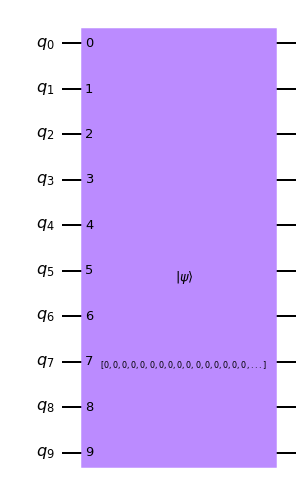

In [36]:
qc = qpie_circuit(im)
qc.draw('mpl')

In [37]:
def decode_out(qc,norm,fourier=False,fourier_inverse=False,shots_mult=1):
    
    n = qc.num_qubits
    shots = shots_mult * 2**20 

    backend = Aer.get_backend('qasm_simulator')
    results = execute(qc, backend=backend, shots=shots, memory=True).result()
    answer = results.get_counts()

    outim = np.zeros((int(2**(n/2)), int(2**(n/2))))

    b = 0
    for i,j in np.ndindex(outim.shape):

        bit = format(b, '0' + str(n) + 'b')
        p_i = answer.get(bit,0)/shots
        
        if fourier:
            pix_val = np.sqrt(p_i) * norm * 2**(n/2)
        
        elif fourier_inverse:
            pix_val = np.sqrt(p_i) * norm / 2**(n/2)
        else:
            pix_val = np.sqrt(p_i) * norm
            
        outim[i,j] = (pix_val)

        b+=1
    
    return outim

float64


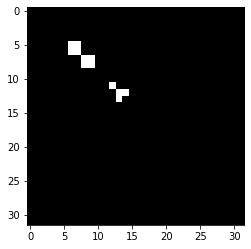

In [38]:
qc.measure_all() 

norm = (np.linalg.norm(im.flatten()))
imout = decode_out(qc,norm)
plt.imshow(imout,cmap='gray')
print(imout.dtype)

In [39]:
def MSE(im1,im2):

    im = (im1-im2)**2
    s = np.sum(im.flatten())/(len(im1**2))
    return s

In [40]:
MSE(im, imout)

8.343791881332062e-07

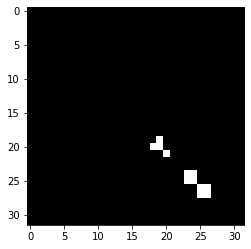

In [41]:
qc = qpie_circuit(ft)

#qc.append(QFT(5,insert_barriers=True, name='QFT'),[0,1,2,3,4])
#qc.append(QFT(5,insert_barriers=True, name='QFT'),[5,6,7,8,9])
qc.append(QFT(5,insert_barriers=True, inverse=False, name='IQFT'),[0,1,2,3,4])
qc.append(QFT(5,insert_barriers=True, inverse=False, name='IQFT'),[5,6,7,8,9])


qc.measure_all()

qc.draw('mpl')

norm = (np.linalg.norm(ft.flatten()))
imout = decode_out(qc,norm,fourier_inverse=True)
plt.imshow(imout,cmap='gray')

In [42]:
MSE(im, imout)

0.37500035762786865

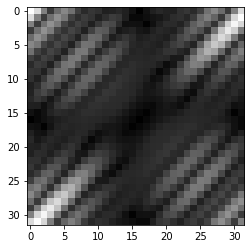

In [28]:
fft = fft2(im)
plt.imshow(np.abs(fft),cmap='gray')

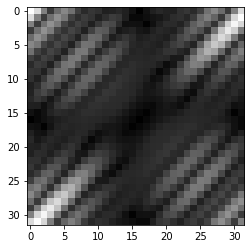

In [29]:
ifft = ifft2(im)
plt.imshow(np.abs(ifft),cmap='gray')

In [30]:
MSE(np.abs(fft), np.abs(ifft))

383.2503662109375

In [31]:
print(np.abs(fft)/np.abs(ifft))

[[1024. 1024. 1024. ... 1024. 1024. 1024.]
 [1024. 1024. 1024. ... 1024. 1024. 1024.]
 [1024. 1024. 1024. ... 1024. 1024. 1024.]
 ...
 [1024. 1024. 1024. ... 1024. 1024. 1024.]
 [1024. 1024. 1024. ... 1024. 1024. 1024.]
 [1024. 1024. 1024. ... 1024. 1024. 1024.]]


<ipython-input-31-d9496c0a76d9>:1: RuntimeWarning: invalid value encountered in true_divide
  print(np.abs(fft)/np.abs(ifft))
